# Nested Sampling with `dynesty`: Dynamic Nested Sampling

This is a simple interactive demo that outlines **dynamic nested sampling** in `dynesty`. See the [documentation](dynesty.readthedocs.io) for additional details.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
np.random.seed(7483)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

# Target Distribution

For this demonstration, we will return to the **correlated multivariate normal** case used earlier with a uniform prior from $[-10, 10]$.

In [4]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

# Drawbacks of "Static" Nested Sampling

In many applications, scientists are often as interested (if not more interested) in estimating the posterior rather than the evidence. From a posterior-oriented perspective, nested sampling's ability to robustly sample from complex, multi-modal distributions often makes it an attractive alternative to methods such as **Markov Chain Monte Carlo (MCMC)**.

However, **nested sampling is designed to estimate the evidence, not the posterior**. In particular, one of the main drawbacks of "static" nested sampling is that we compress *linearly* in $\ln X_i$ at all times, regardless of where the majority of posterior mass is located. We illustrate this behavior directly below.

In [5]:
# initialize our "static" nested sampler
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                bound='single', nlive=1000)

# sample from the distribution
sampler.run_nested(dlogz=0.01)

# grab our results
res = sampler.results

iter: 13301 | +1000 | bound: 14 | nc: 1 | ncall: 56724 | eff(%): 25.212 | loglstar:   -inf < -0.294 <    inf | logz: -8.978 +/-  0.085 | dlogz:  0.000 >  0.010                                       

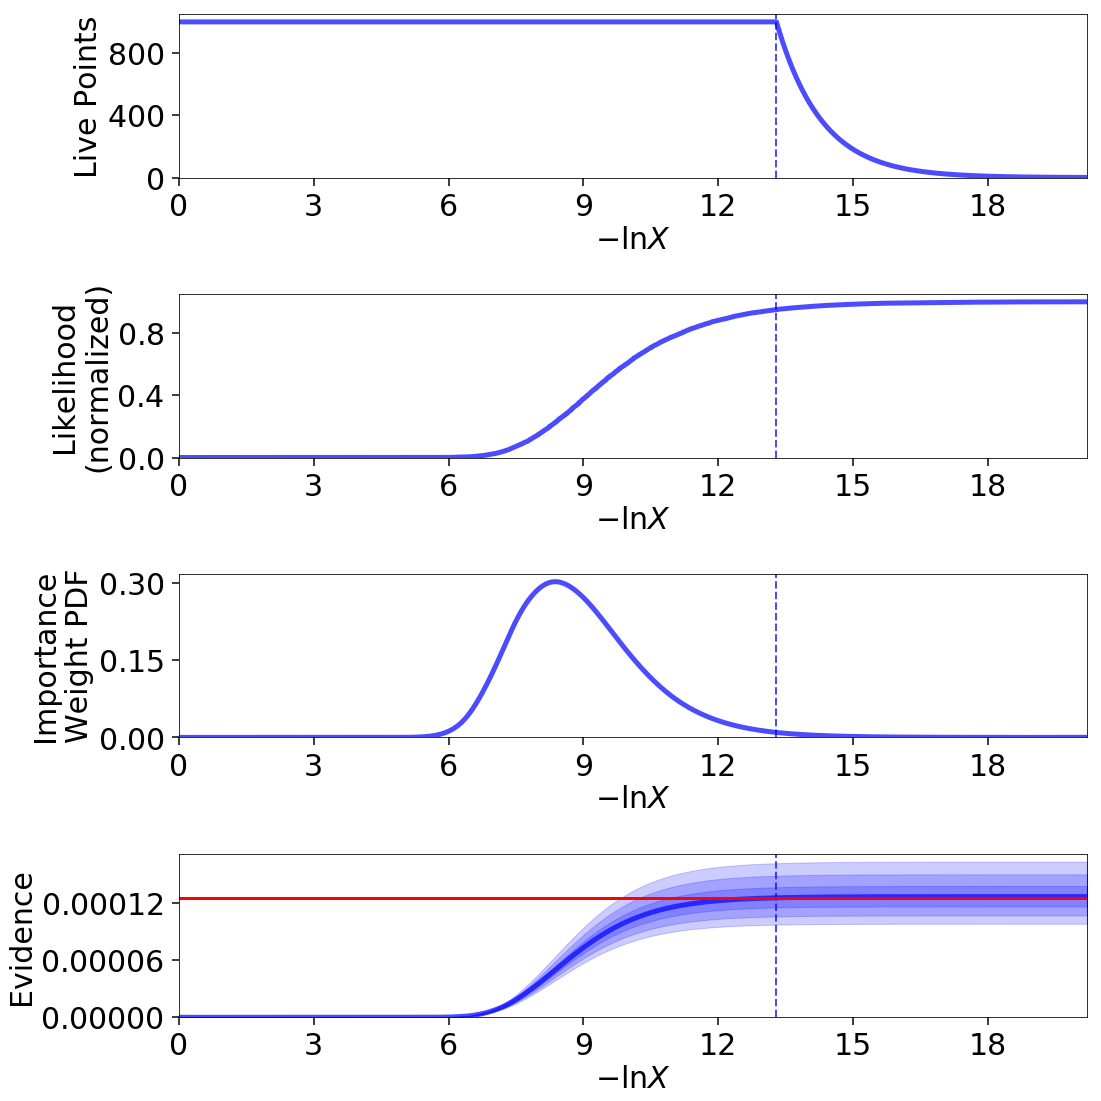

In [6]:
from dynesty import plotting as dyplot

lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(res, lnz_truth=lnz_truth)
fig.tight_layout()

In this particular example, approximately a third of our samples give negligible contributions to the posterior. While these samples are crucial for evidence estimation (since they provide information on the current prior volume $ln X_i$), they are essentially useless when constructing posterior density estimates.

# Dynamic Nested Sampling

Dynamic sampling in `dynesty` can be accessed using `DynamicNestedSampler` (in contrast to the `NestedSampler`) and can be initialized using a very similar API. One key difference, however, is that we don't need to declare the number of live points upon initialization.

In [7]:
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                        bound='single', sample='unif')

We'll compare our results using several different test cases to illustrate different aspects of the dynamic nested sampling.

## Case 1: Equal Number of Samples

In the first case, we'll use 50 live points to lay down our "baseline" run defining our initial distribution, and then add batches of 50 live points until we reach the same total number of iterations (samples) as with the Static Nested Sampling case.

In [8]:
# sample dynamically from the target distribution
dsampler.run_nested(nlive_init=50, nlive_batch=50,
                    maxiter=res.niter+res.nlive, use_stop=False)

# save results
dres = dsampler.results

iter: 14301 | batch: 62 | bound: 392 | nc: 1 | ncall: 37803 | eff(%): 37.830 | loglstar: -6.195 < -0.351 < -1.108 | logz: -8.877 +/-  0.137 | stop:    nan                                            


Notice that since we've optimized our dynamic sampler for posterior estimation over evidence estimation (via the default weight function), the errors on our evidence estimates have gotten significantly larger. Since we are adding points in much smaller batches, we also use a lot more bounding objects since we update more frequently.

Note that the `Results` dictionary from `dsampler` has a slightly different set of stored values than `sampler`.

In [9]:
print('Static Nested Sampling:', res.keys())
print('Dynamic Nested Sampling:', dres.keys())

Static Nested Sampling: dict_keys(['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'])
Dynamic Nested Sampling: dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale'])


In detail:
- **`samples_n`**: gives the number of live points at a given iteration (stored instead of `nlive`).
- **`samples_batch`**: index of the batch the points were sampled from.
- **`batch_nlive`**: tracks the number of live points added in a given batch.
- **`batch_bounds`**: the log-likelihood bounds used to bound the dead points from a given batch.

Note that, similar to the `NestedSampler`, our `DynamicNestedSampler` can also add samples externally using generators. See the documentation for additional examples.

Let's now examine two edge cases: one where we sample with 100% of the weight placed on the posterior and one where we put 100% of the weight on the evidence.

In [10]:
# posterior case
dsampler.reset()
dsampler.run_nested(nlive_init=50, nlive_batch=50,
                    maxiter=res.niter+res.nlive, use_stop=False, 
                    wt_kwargs={'pfrac': 1.0})
dres_p = dsampler.results

iter: 14316 | batch: 71 | bound: 412 | nc: 3 | ncall: 30890 | eff(%): 46.345 | loglstar: -8.855 < -0.817 < -1.129 | logz: -9.267 +/-  0.374 | stop:    nan                                            


In [11]:
# evidence case
dsampler.reset()
dsampler.run_nested(nlive_init=50, nlive_batch=50,
                    maxiter=res.niter+res.nlive, use_stop=False, 
                    wt_kwargs={'pfrac': 0.0})
dres_z = dsampler.results

iter: 14301 | batch: 30 | bound: 0 | nc: 1 | ncall: 68940 | eff(%): 20.744 | loglstar:   -inf < -40.112 < -2.295 | logz: -9.007 +/-  0.075 | stop:    nan                                             


## Case 2: Automated Stopping Criteria

For our second case, we will restart from the beginning and keep adding samples (with the default settings) until we satisfy the default stopping criterion implemented in `dynesty`.

In [12]:
# add samples in batches until we satisfy the default stopping criterion
psampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                        bound='single', sample='unif')
psampler.run_nested()

# save results
pdres = psampler.results

iter: 22165 | batch: 10 | bound: 56 | nc: 1 | ncall: 55509 | eff(%): 39.930 | loglstar: -7.838 < -0.298 < -0.789 | logz: -9.115 +/-  0.116 | stop:  0.970                                             


In [13]:
# posterior-oriented run
psampler.reset()
psampler.run_nested(wt_kwargs={'pfrac': 1.0})
pdres_p = psampler.results

iter: 21597 | batch: 10 | bound: 56 | nc: 1 | ncall: 55058 | eff(%): 39.226 | loglstar: -6.004 < -0.299 < -0.854 | logz: -8.995 +/-  0.116 | stop:  0.923                                             


In [14]:
# evidence-oriented run
psampler.reset()
psampler.run_nested(wt_kwargs={'pfrac': 0.0}, stop_kwargs={'pfrac': 0.0})
pdres_z = psampler.results

iter: 16031 | batch: 2 | bound: 29 | nc: 1 | ncall: 77598 | eff(%): 20.659 | loglstar:   -inf < -0.346 < -1.851 | logz: -8.812 +/-  0.085 | stop:  0.990                                              


These results give answers that are similar to those derived using a fixed number of iterations.

# Visualizing Results

We can see the impact our samples have on our inference using the same plotting diagnostics as before.

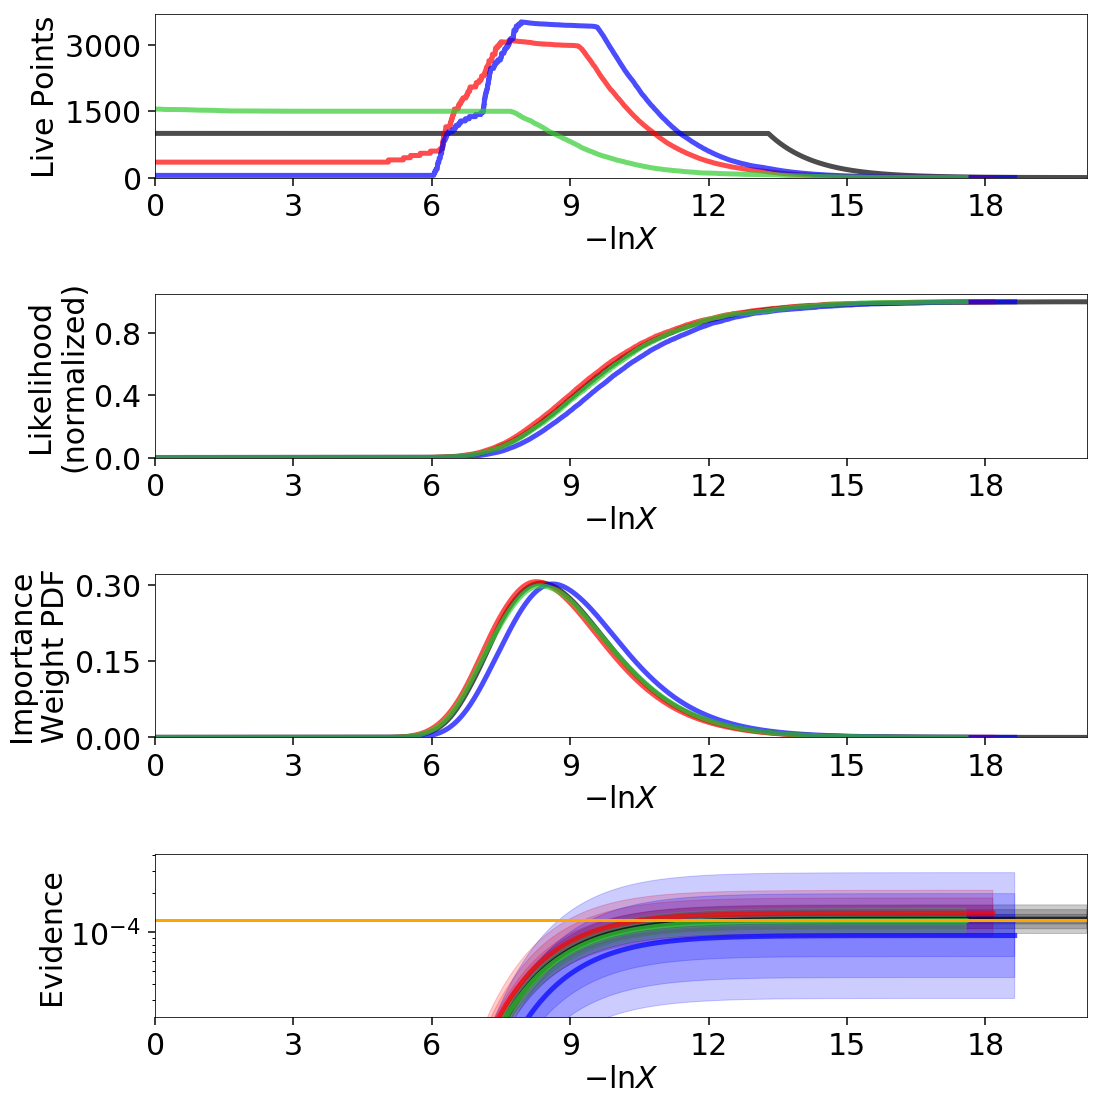

In [15]:
# plot static run with fixed number of live points
fig, axes = dyplot.runplot(res, color='black', mark_final_live=False, logplot=True)

# overplot default dynamic run
fig, axes = dyplot.runplot(dres, color='red',
                           logplot=True, fig=(fig, axes))

# overplot posterior-oriented dynamic run
fig, axes = dyplot.runplot(dres_p, color='blue',
                           logplot=True, fig=(fig, axes))

# overplot evidence-oriented dynamic run
fig, axes = dyplot.runplot(dres_z, color='limegreen',
                           logplot=True, fig=(fig, axes), 
                           lnz_truth=lnz_truth,  truth_color='orange')

fig.tight_layout()

Our dynamic sampler is doing exactly what we want: although we ultimately are using the same amount of samples, the places where they are located differs dramatically among our runs. For the posterior-oriented cases, we spend (significantly) less time sampling regions with little posterior weight and with samples concentrated around the bulk of the posterior mass. Conversely, in the evidence-oriented case we spend many fewer samples tracing out the bulk of the posterior mass. 

The general shape of the dynamic runs traces the overall shape of the weights: our posterior-based samples are concentrated around the bulk of the posterior mass while the evidence-based samples are concentrated away from the bulk of the posterior mass. The general skewness to the distribution is primarily because we recycle any live points sampled past the log-likelihood bounds during each batch. This allows us to get more information "inward" of the bounds whenever we add a batch, so as a result when we allocate new samples we tend to systematically skew "outward".

This behavior can be made more apparent by looking at our results using `traceplot` and `cornerpoints`.

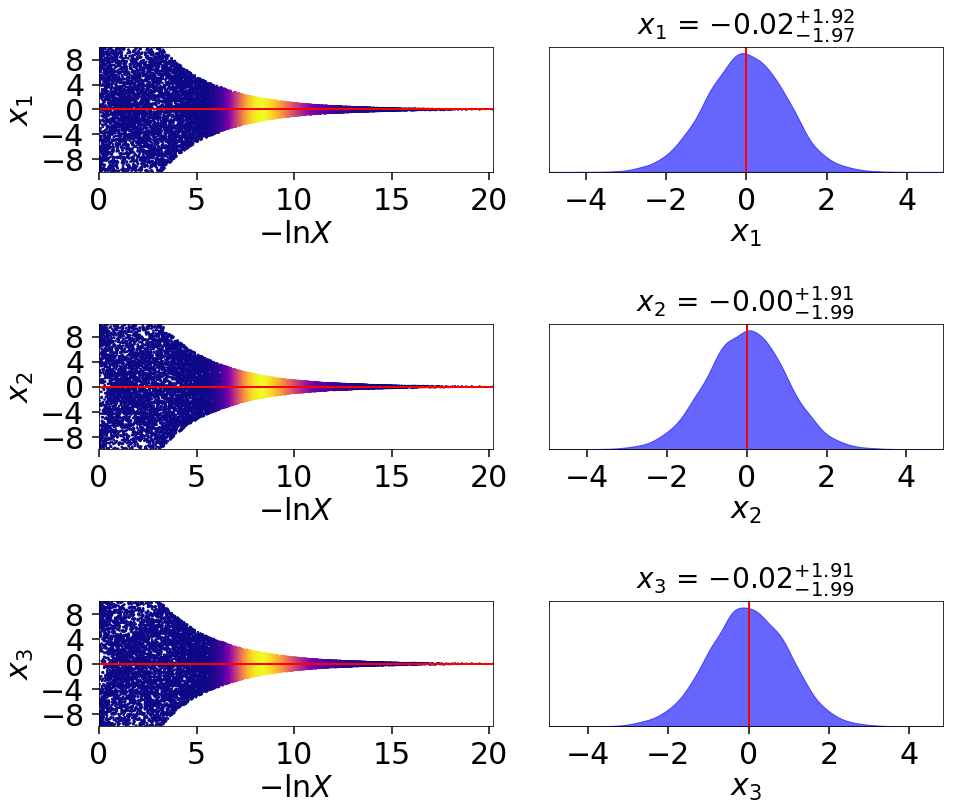

In [16]:
# plotting the static run
fig, axes = dyplot.traceplot(res, truths=np.zeros(ndim), show_titles=True, trace_cmap='plasma',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

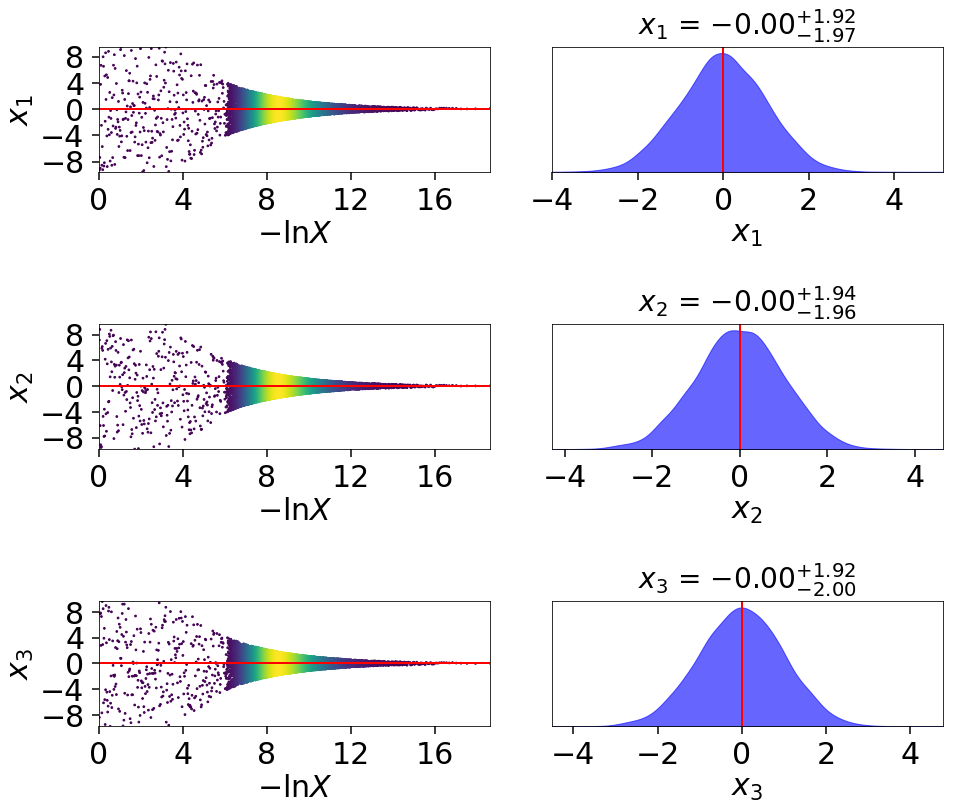

In [17]:
# plotting the posterior-oriented dynamic run
fig, axes = dyplot.traceplot(dres_p, truths=np.zeros(ndim), show_titles=True, trace_cmap='viridis',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

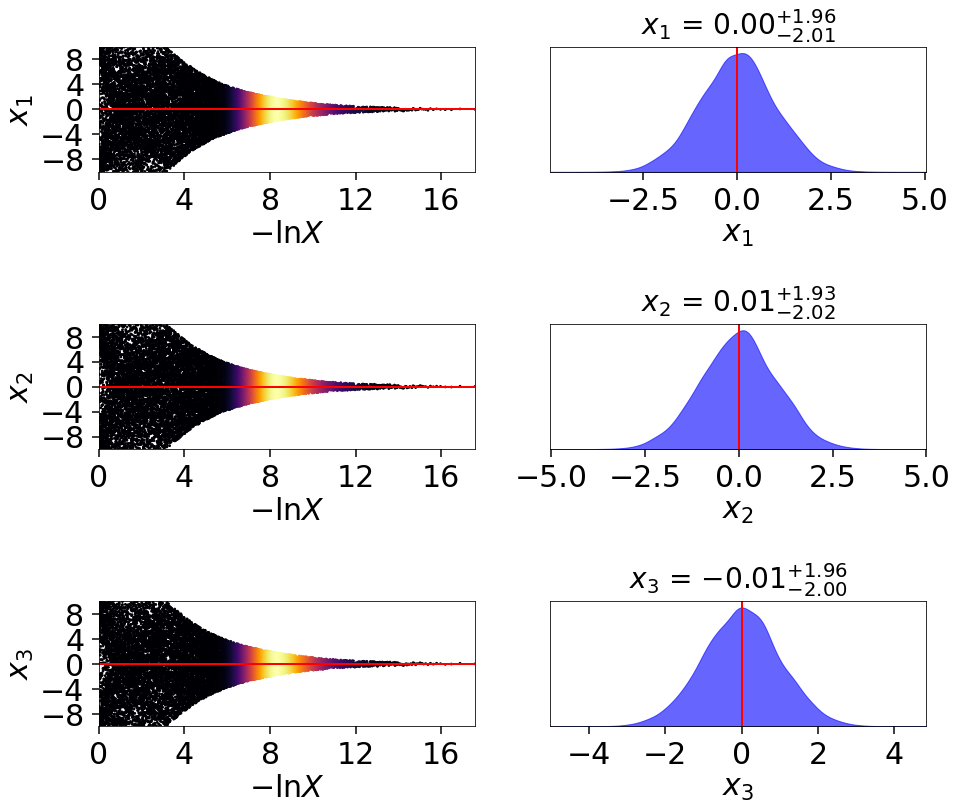

In [18]:
# plotting the evidence-oriented dynamic run
fig, axes = dyplot.traceplot(dres_z, truths=np.zeros(ndim), show_titles=True, trace_cmap='inferno',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

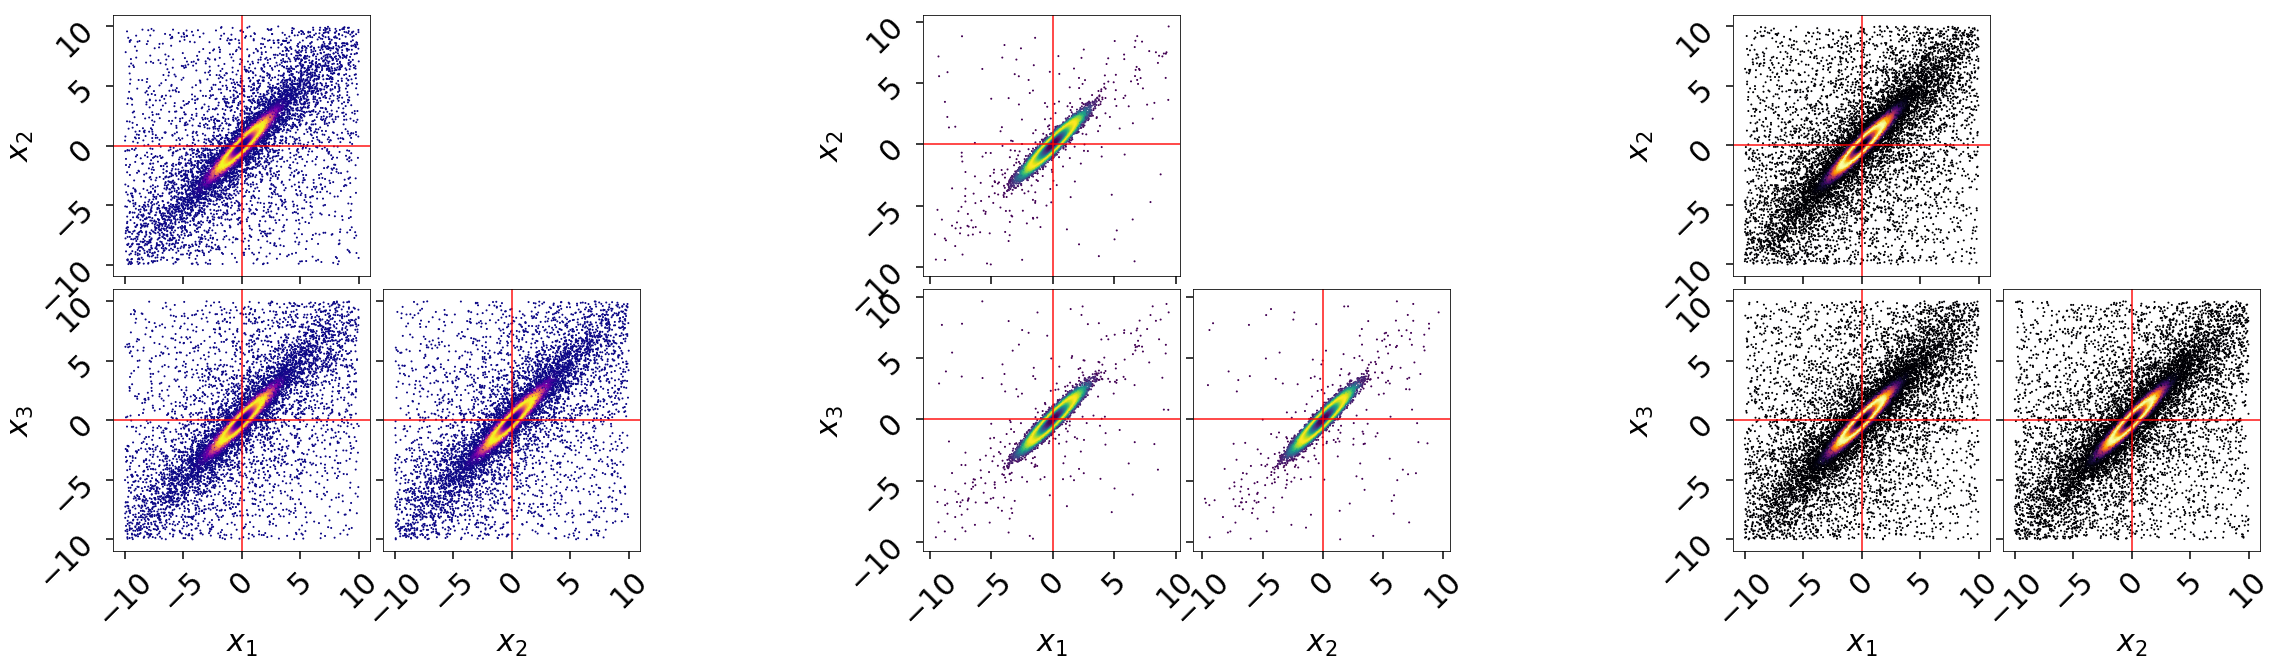

In [19]:
# initialize figure
fig, axes = plt.subplots(2, 8, figsize=(40, 10))
axes = axes.reshape((2, 8))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]
[a.set_frame_on(False) for a in axes[:, 5]]
[a.set_xticks([]) for a in axes[:, 5]]
[a.set_yticks([]) for a in axes[:, 5]]

# plot static run (left)
fg, ax = dyplot.cornerpoints(res, cmap='plasma', truths=np.zeros(ndim),
                             fig=(fig, axes[:, 0:2]))

# plot posterior-oriented dynamic run (middle)
fg, ax = dyplot.cornerpoints(dres_p, cmap='viridis', truths=np.zeros(ndim),
                             fig=(fig, axes[:, 3:5]))

# plot evidence-oriented dynamic run (right)
fg, ax = dyplot.cornerpoints(dres_z, cmap='inferno', truths=np.zeros(ndim),
                             fig=(fig, axes[:, 6:8]))

Finally, let's take a look at how this roughly impacts the quality of our inferred posterior.

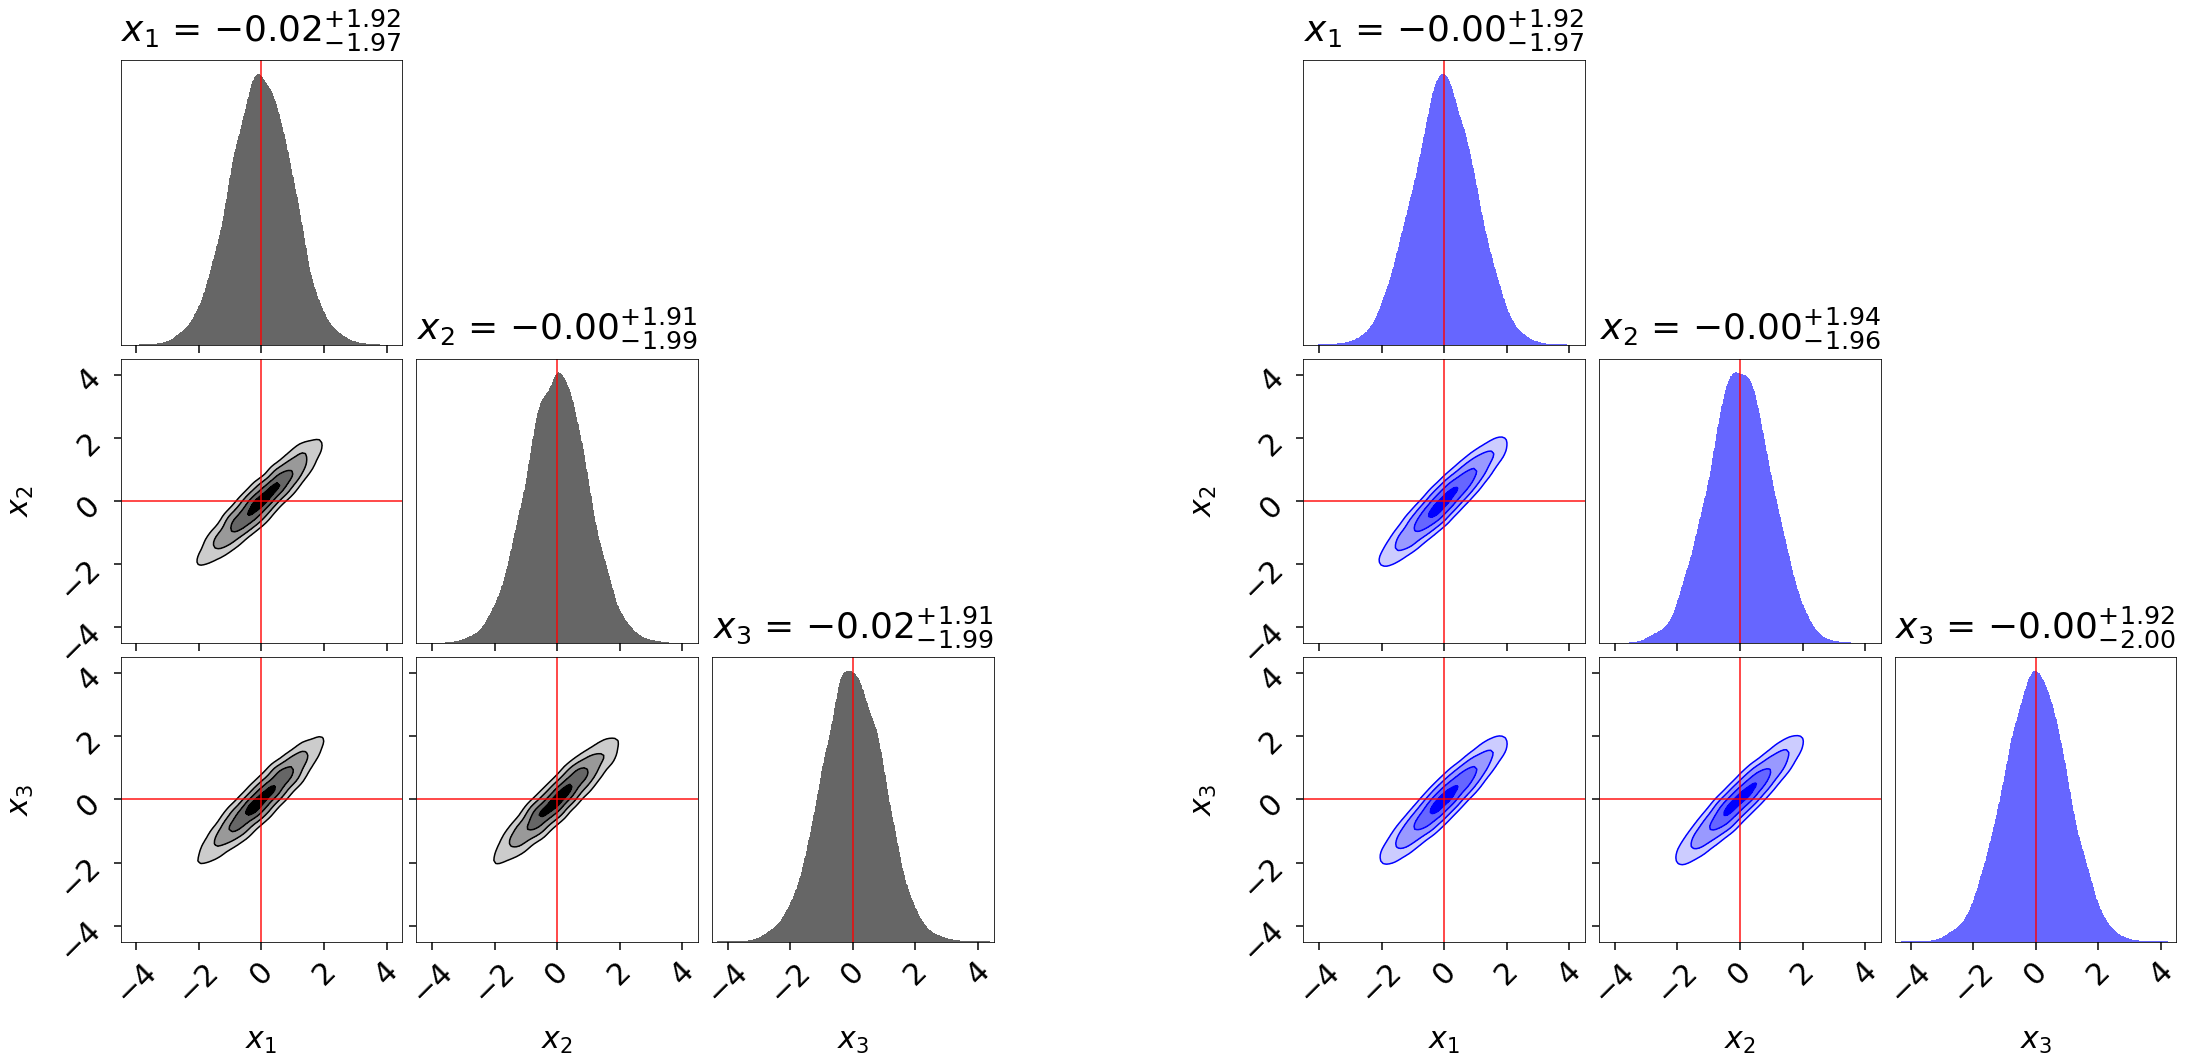

In [20]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='black', truths=np.zeros(ndim),
                           span=[(-4.5, 4.5) for i in range(ndim)],
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(dres_p, color='blue', truths=np.zeros(ndim),
                           span=[(-4.5, 4.5) for i in range(ndim)],
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, 4:]))

# Summary

"Static" nested sampling is designed to derive Bayesian evidences with posteriors as a by-product. Dynamic nested sampling builds on this general framework to allocate samples dynamically to prioritize arbitrary weight functions. This allows nested sampling to be used for, e.g., targeted posterior estimation (the default behavior) over evidence calculations. In addition, dynamic nested sampling can also accomodate arbitray stopping criteria, including generalized measures of posterior convergence (the default behavior).